# Open Grid TD animation

This example demonstrates how to use the discrete Temporal Difference
Reinforcement Learning algorithms (SARSA, Q, Q(lambda)) in a classical
fully observable MDP maze task. The goal point is in the lower right corner.

In [1]:
# prepare plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
# rcParams['animation.writer'] = 'ffmpeg'

In [2]:
__author__ = 'Thomas Rueckstiess, ruecksti@in.tum.de, John Mark Agosta, john-mark.agosta@microsoft.com'

import numpy as np
from pybrain.rl.environments.mazes import Maze, MDPMazeTask
from pybrain.rl.learners.valuebased import ActionValueTable
from pybrain.rl.agents import LearningAgent
from pybrain.rl.learners import Q, QLambda, SARSA #@UnusedImport
from pybrain.rl.explorers import BoltzmannExplorer #@UnusedImport
from pybrain.rl.experiments import Experiment

In [3]:
def open_field(x_dim, y_dim):
    'Create a matrix of zeros surrounded by ones.'
    grid = np.zeros((y_dim, x_dim), dtype='int')
    # top and bottom boundaries
    horz_boundary = np.ones((1, x_dim), dtype='int')
    grid = np.concatenate((horz_boundary, grid, horz_boundary), axis=0)
    # right and left
    vert_boundary = np.ones((y_dim+2, 1), dtype='int')
    grid = np.concatenate((vert_boundary, grid, vert_boundary), axis=1)
    return grid

GRID_X = 7
GRID_Y = 7


The RL Q-learner consists of an _agent_ that incorporates a learning algorithm and an _environment_ with the maze to be solved. The _experiment_ combines the agent and environment.

In [4]:
grid = open_field(GRID_X, GRID_Y)
env = Maze(grid, (GRID_X, GRID_Y))

# create task
task = MDPMazeTask(env)

# create action - value table and initialize with ones
table = ActionValueTable(81, 4)   # TODO: How is 81 derived from 7 x 7 ?
table.initialize(1.)

# create agent's controller and learner - use SARSA(), Q() or QLambda() here
learner = SARSA()

# standard exploration is e-greedy, but a different type can be chosen as well
# learner.explorer = BoltzmannExplorer()

# create agent
agent = LearningAgent(table, learner)

# create experiment
experiment = Experiment(task, agent)

In [5]:
def tb_max(tbl):
    'Grab the max value of the value matrix.'
    tb = tbl.params.reshape(81,4).max(1).reshape(9,9)
    return max(tb.flatten())
tb_max(table)

1.0

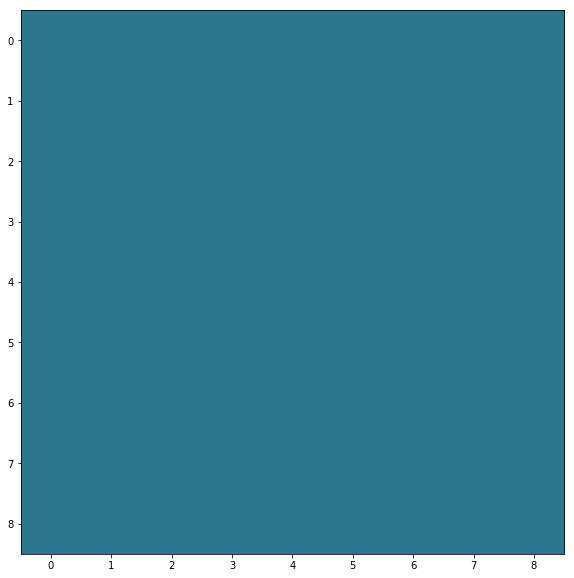

In [6]:
# Initialize the animation plot
fig, ax = plt.subplots(figsize= (10,10))

#ax.set_xlim(( 0, 9))
#ax.set_ylim((0, 9))
grid = np.zeros((9,9))
grid[4,4] = 1       # Place an obstacle in the field              
im_base = plt.imshow(grid, vmin=0, vmax=2.5, animated=True)
tmax = []

def im_init():
    table.initialize(1.0)
    im_base.set_data(table.params.reshape(81,4).max(1).reshape(9,9))
    return [im_base]
im_init()

In [7]:
def im_animate(i):
    'Run the reinforcement learner and plot each value update. '
    # interact with the environment (here in batch mode)
    experiment.doInteractions(100)
    agent.learn()
    agent.reset()

    y = table.params.reshape(81,4).max(1).reshape(9,9)
    # Highlight the goal.  
    y[7,7]  = max(y.flatten())
    # plot
    im_base.set_array(y)
    tmax.append(tb_max(table))
    return [im_base]

In [8]:
# call the animator. blit=True means only re-draw the parts that have changed.
# See http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
im_anim = animation.FuncAnimation(fig, im_animate, init_func=im_init,
                               frames=160, interval=80, blit=True)

We run the experiment, displaying an animated plot of the maze as the value improves. (This takes about 30 seconds.)

In [9]:
HTML(im_anim.to_html5_video())

The final value matrix, showing a clear gradient toward the goal in the lower right-hand corner.

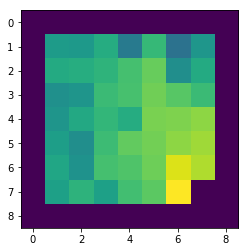

In [10]:
plt.imshow(table.params.reshape(81,4).max(1).reshape(9,9))

In [11]:
# Save the video animation in mp4 format, playable by
# ffplay maze_200frame_1.mp4
#
im_anim.save("open_maze_160frame.mp4")